## Assignment 3

#### The project aims to design a vehicle (agent) for navigating a copper mine environment, ensuring safe traversal from the start position (S) to the goal (G) while avoiding pits and restricted areas. This involves defining the environment, designing the agent's behavior, implementing movement logic, training the agent using reinforcement learning techniques, testing its performance, and refining its design based on evaluation results.

<img src="Figure2.png" alt="Grid cell" width="200" height="200" align="left">


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Helper method for different functionality, it does the following task 

**is_valid:** Checks if a given state falls within the grid boundaries, ensuring it's a valid position for the agent to occupy.

**is_dangerous:** Determines if a state corresponds to a dangerous pit or no-go zone within the environment.

**is_wall:** Identifies if a state represents a wall or barrier, restricting the agent's movement within the grid.

**get_valid_next_state:** computes the next state that the agent will transition to based on its current state and the chosen action. It considers the direction specified by the action (e.g., moving up, down, left, or right) and computes the new state accordingly. Additionally, it ensures that the next state remains within the boundaries of the grid by controlling the coordinates to valid values. This prevents the agent from moving outside the grid or accessing invalid positions. The function returns the computed next state, ensuring that it adheres to the constraints of the environment.

**get_reward:** determines the reward obtained by the agent for transitioning from the current state to the next state based on the action taken. It considers various factors such as whether the next state reaches the goal position, if it falls into a dangerous pit or a wall, or if it remains within the grid boundaries. The function assigns different rewards accordingly, such as a high positive reward for reaching the goal, negative rewards for encountering dangerous pits or walls, and penalties for invalid or stationary actions.

**print_grid:** Displays the grid environment, marking the agent's position, paths, and negative rewards associated with pits, walls, or invalid states. Here S=Start, G=Goal, W=Wall, D=Dangerous Pit and A=Agent

In [2]:
# Function to check if a state is valid
def is_valid(state):
    x, y = state
    return 0 <= x < grid_size[0] and 0 <= y < grid_size[1]

# Function to check if a state is dangerous (pit or no-go zone)
def is_dangerous(state):
    return state in dangerous_pit_positions

# Function to check if a state is a wall
def is_wall(state):
    return state in wall_positions

# Function to get a valid next state for a given action
def get_valid_next_state(state, action):
    dx, dy = action
    next_state = (state[0] + dx, state[1] + dy)

    # stop next state to stay within grid boundaries
    next_state = (max(0, min(next_state[0], grid_size[0] - 1)),
                  max(0, min(next_state[1], grid_size[1] - 1)))

    #print(next_state)
    return next_state

# Function to get the reward for a transition
def get_reward(current_state, action, next_state):
    if next_state == goal_position:
        return 10, False
    elif is_dangerous(next_state):
        return -10, True
    elif is_wall(next_state):
        return -5, True
    elif not is_valid(next_state):
        return -2, False  # Penalty for invalid state
    elif next_state[0] == current_state[0] and next_state[1] == current_state[1]: #if staying at the same grid
        return -1, False  # Penalty for staying still
    else:
        return -0.1, False   #this means it is moving to next grid

# Function to print the grid with agent's position, path, and negative rewards
def print_grid(agent_position):
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i, j) == agent_position:
                print("S ", end="") if agent_position == (0, 0) else print("A ", end="")
            elif (i, j) == goal_position:
                print("G ", end="")
            elif is_dangerous((i, j)):
                print("D ", end="")
            elif is_wall((i, j)):
                print("W ", end="")
            else:
                print("- ", end="")
        print()


### The below section calls the helper method defined above and initiate variables and train the model
In this iterative learning process, the agent navigates a dynamic environment, making decisions based on exploration and exploitation. It seeks the optimal path to the goal while avoiding pitfalls and obstacles. Q-values are updated, guiding the agent toward efficient decision-making for safe and successful navigation.We will try to answer the following question for gaining more details


- **What are the states in the layout?**

  The states are defined by first establishing the grid size and position tuple. After that, we set two lists of tuples called dangerous_pit_positions and wall_positions. These are printed to display the initial state and how the grid is laid out.
  
  </br>
- **What are the actions for the vehicle?**

  The action is defined in the actions tuple list, where it can move right, left, down, up, or stay still. While training the model, we determine the action_index using exploitation or exploration through epsilon.
  
  </br>
- **Which algorithm you will go for and why ?**
  
   In the question, it provided details that the copper mine is not a well-defined area, and the vehicle needs to navigate safely to the goal G. Considering this, I have opted for a model-free approach. As there are dangerous pits, prioritizing safety, SARSA is more reliable. Therefore, it utilizes the SARSA algorithm, which is defined in the is_valid block.
   
   </br>
- **How would you design the rewards?**

    To design the rewards in the context of the provided code, we consider the rewards returned by the get_rewards method, this will give different score for different actions, in thsi method we can see the reward scheme: 1) Reach goal: +10, 2) Encounter danger: -10, 3) Hit wall: -5, 4) Invalid state: -2, 5) Stay: -1, 6) Move: -0.1. this are considerd in each episode while training the model.


Initial State:
S - - - D 
D - - W - 
- - - - - 
- W - D - 
D - - - G 

Final State:
- - - - D 
D - - W - 
- - - - - 
- W - D - 
D - - - A 
Training complete!


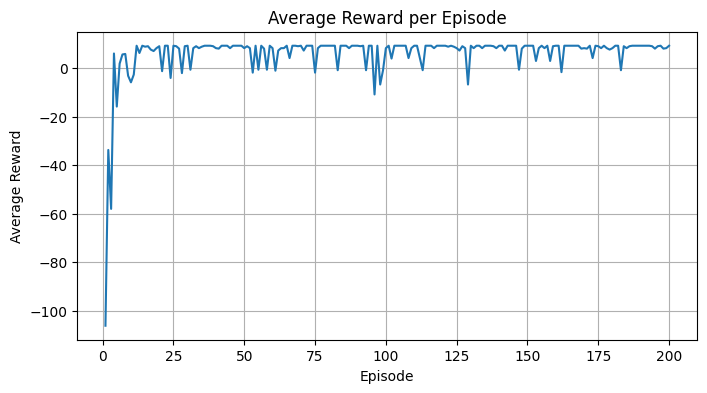

In [3]:
# Define grid size and goal position
grid_size = (5, 5)
goal_position = (4, 4)

dangerous_pit_positions = [(1, 0), (0, 4), (3, 3), (4, 0)]

wall_positions = [(1, 3), (3, 1)]

actions = [(0, 1), (0, -1), (1, 0), (-1, 0), (0, 0)] #move RIGHT, LEFT, DOWN, UP, STAY STILL

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0] * grid_size[1], len(actions)))

# initialize alpha/gamma/episolon for training, this can be tweaked for training
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

avg_reward_per_episode = []

# Print initial state before learning
print("Initial State:")
initial_state = (0, 0)  # Initial position
print_grid(initial_state)

# Training loop
episodes = 200  # Set number of episodes
for episode in range(episodes):
    state = initial_state  # Start at initial position   
    negative_rewards = []  # Keep track of states with negative rewards
    total_reward = 0
    step_count = 0
    while state != goal_position and step_count <= 100:  # for each episode, it will take 100 steps
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action_index = np.random.randint(len(actions))  # Explore randomly
        else:
            action_index = np.argmax(Q[state[0] * grid_size[0] + state[1], :])  

        action = actions[action_index]
        next_state = get_valid_next_state(state, action)  # Get valid next state
        reward, is_negative = get_reward(state, action, next_state)

        # Update Q-value using SARSA rule
        if is_valid(next_state):
            next_action_index = np.argmax(Q[next_state[0] * grid_size[0] + next_state[1], :])  # Greedy action in next state
            Q[state[0] * grid_size[0] + state[1], action_index] += alpha * (reward + gamma * Q[next_state[0] * grid_size[0] + next_state[1], next_action_index] - Q[state[0] * grid_size[0] + state[1], action_index])

        state = next_state        
        if is_negative:
            negative_rewards.append(state)  # Add state with negative reward to the list
        total_reward += reward
        step_count += 1

    avg_reward_per_episode.append(total_reward)

# Print final state after all episodes
print("\nFinal State:")
print_grid(state)
print("Training complete!")

# Plot Average Reward per Episode
plt.figure(figsize=(8, 4))
plt.plot(range(1, episodes + 1), avg_reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.grid(True)
plt.show()